In [44]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
REPO_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan')
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata')

# Galsim: demo[0-9].py

In [39]:
gal_flux = 1.e5    # total counts on the image
rhalf = 2.     # arcsec
psf_sigma = 1.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30. # standard 

gal = galsim.Sersic(1,flux=gal_flux, half_light_radius=rhalf)
gal = gal.shear(e1=0.3, e2=-0.8)
rot_gal= gal.rotate(np.pi/2.* galsim.radians)
psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

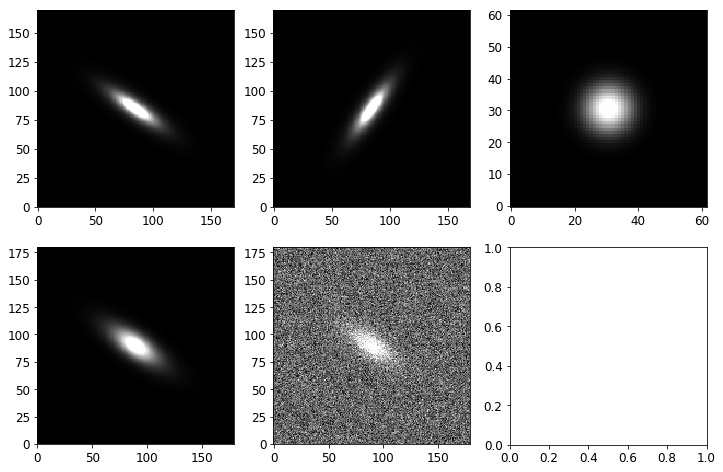

In [41]:
class plotImage(object):
    """Helper functions for displaying image and overlaying circles around sources
    
    Args:
        img: need to give as initial input b/c some helper funcs that dont directly
            use img, need its shape at least, see circles()
    """
    def imshow(self,img,ax,qs=[0.5,99.5]):
        if img.shape[-1] == 3:
            #minmax=np.percentile(np.sum(img,axis=2),q=qs)
            minmax=[None,None]
            cmap=None
        else:
            minmax=np.percentile(img,q=qs)
            cmap='gray'
        ax.imshow(img, interpolation='none', origin='lower',
                  cmap=cmap,vmin=minmax[0],vmax=minmax[1])
        ax.tick_params(direction='out')

fig,ax= plt.subplots(2,3,figsize=(12,8))
kw={'scale':pixel_scale}
plotImage().imshow(gal.drawImage(**kw).array,ax[0,0])
plotImage().imshow(rot_gal.drawImage(**kw).array,ax[0,1])
plotImage().imshow(psf.drawImage(**kw).array,ax[0,2])
plotImage().imshow(final.drawImage(**kw).array,ax[1,0])
plotImage().imshow(image.array,ax[1,1])

# DECam CCD + PSFex psf

In [47]:
from legacypipe.decam import DecamImage
from legacypipe.survey import LegacySurveyData

In [60]:
ccds= fits_table(os.path.join(DATA_DIR,
                             '1741p242/dr5/legacysurvey-1741p242-ccds.fits'))
t= ccds[((pd.Series(ccds.image_filename).str.contains('c4d_160116_084245_oki_z_v1.fits')) &
         (ccds.ccdname == 'S17'))]
for col in ['image_filename','ccdname','filter','camera']:
    t.set(col,t.get(col)[0])
t

<tabledata object with 1 rows and 52 columns: wcsplver=V3.9  , crpix1=6659.0, crpix2=-82.6666, ccdraoff=-0.243037, mjd_obs=57403.3615281, cd2_1=-7.28811e-05, ccdzpt=24.8024, cd2_2=-9.65829e-08, propid=2014B-0404, ra_bore=173.987, fwhm=3.39651, ccdname=S17, image_filename=decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz     , filter=z, brick_y0=2966, image_hdu=15, psfnorm=0.15723, galnorm=0.112069258342, width=2046, ccdnmatch=47, camera=decam, has_zeropoint=True, zpt=24.8171, ra=174.158550288, object=DECaLS_3231_z                      , crval2=23.9982815878, skyrms=1.02796, crval1=173.987009889, ccd_y0=1, ccd_y1=3343, skyplver=V3.9    , depth_cut_ok=True, sig1=0.0312411400471, cd1_1=-9.75879e-08, expnum=511967, height=4094, exptime=80.0, plver=V3.9  , cd1_2=7.2856e-05, brick_x0=-1, brick_x1=3361, ccddecoff=-0.200546, ccd_cuts=0, brick_y1=3608, psfver=dr3b-7-gc8e714f  , ccd_x1=2046, ccd_x0=1414, skyver=dr3b-7-gc8e714f  , dec_bore=23.9982777778, wcsver= , dec=24.4098851019, ps

In [62]:
survey=LegacySurveyData()
di= DecamImage(survey,t)
tim = di.get_tractor_image()

On NERSC, you can do:
  module use /project/projectdirs/cosmo/work/decam/versions/modules
  module load legacysurvey

Now using the current directory as LEGACY_SURVEY_DIR, but this is likely to fail.



IOError: File not found: '/home/kaylan/myrepo/obiwan/doc/nb/images/decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz'

In [59]:
t.image_filename

'd'